In [9]:
import torch
from torchvision import transforms
from timm import create_model
import torch.nn.functional as F
from datasets import load_dataset
import lightning as L
from torchmetrics.utilities.data import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
# https://huggingface.co/datasets/sasha/chihuahua-muffin
ds = load_dataset("sasha/chihuahua-muffin")
split_dataset = ds['train'].train_test_split(test_size=0.25)

In [4]:
# Define preprocessing transformations
DEFAULT_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Apply transformations using map() with parallel processing
split_dataset = split_dataset.map(
  lambda example: {'image': DEFAULT_TRANSFORM(example['image'])},
  num_proc=4
)

Map (num_proc=4):   0%|          | 0/224 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/75 [00:00<?, ? examples/s]

In [6]:
# Create dataloaders
split_dataset.set_format(type="torch", columns=["image", "label"])
batch_sizes = (12, 4)
train_dataloader = torch.utils.data.DataLoader(
  split_dataset['train'],
  batch_size=batch_sizes[0],
  shuffle=True,
  num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
  split_dataset['test'],
  batch_size=batch_sizes[1],
  num_workers=4
)

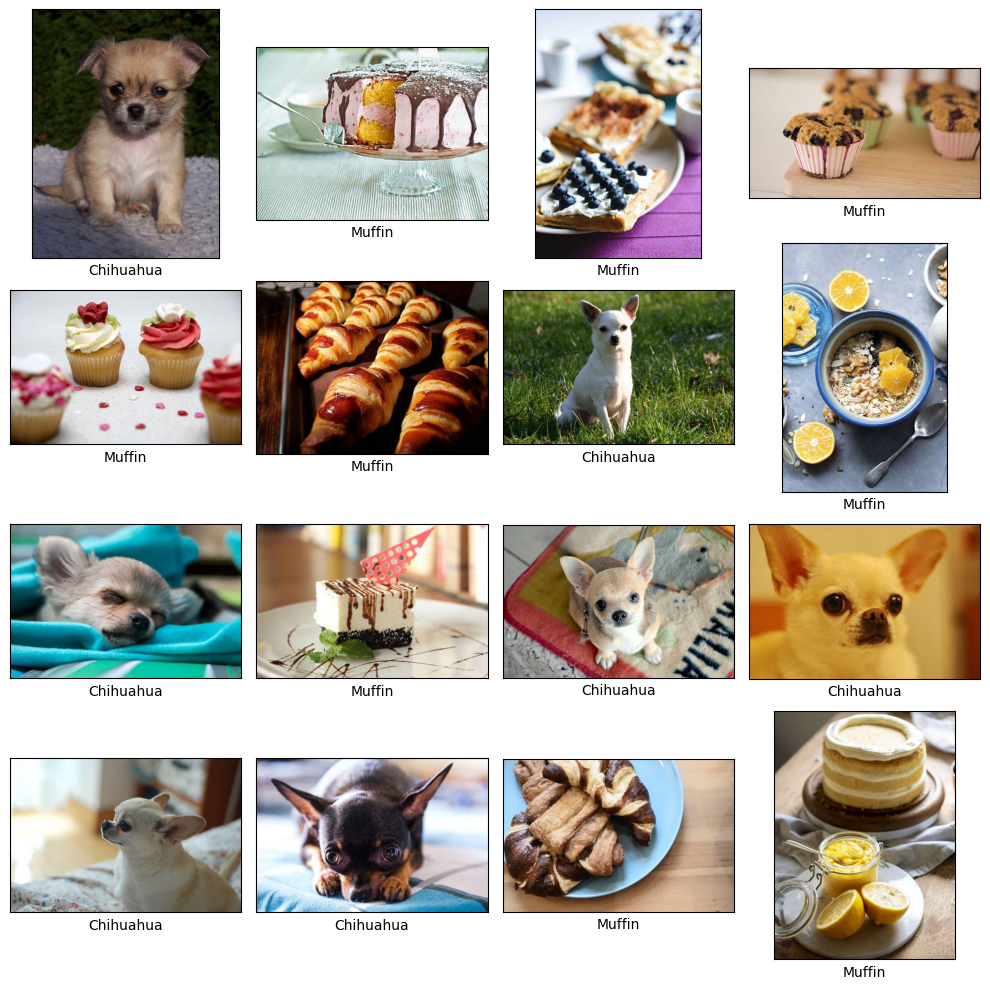

In [7]:
fig = plt.figure(figsize=(10,10))
random_integers = []
for _ in range(16):
    random_integers.append(random.randint(0, len(ds["train"])))
for i, z in zip(random_integers, range(16)):
    fig.add_subplot(4, 4, z+1) 
    plt.imshow(ds['train'][i]["image"])
    if ds['train'][i]["label"] == 0:
        label = 'Muffin'
    else:
        label = 'Chihuahua'
    plt.xlabel(f'{label}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.075384..2.5953326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7972503..2.2481313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5196526].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0014782..2.6391766].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0762253..2.6178606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9999709..2.4148655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..

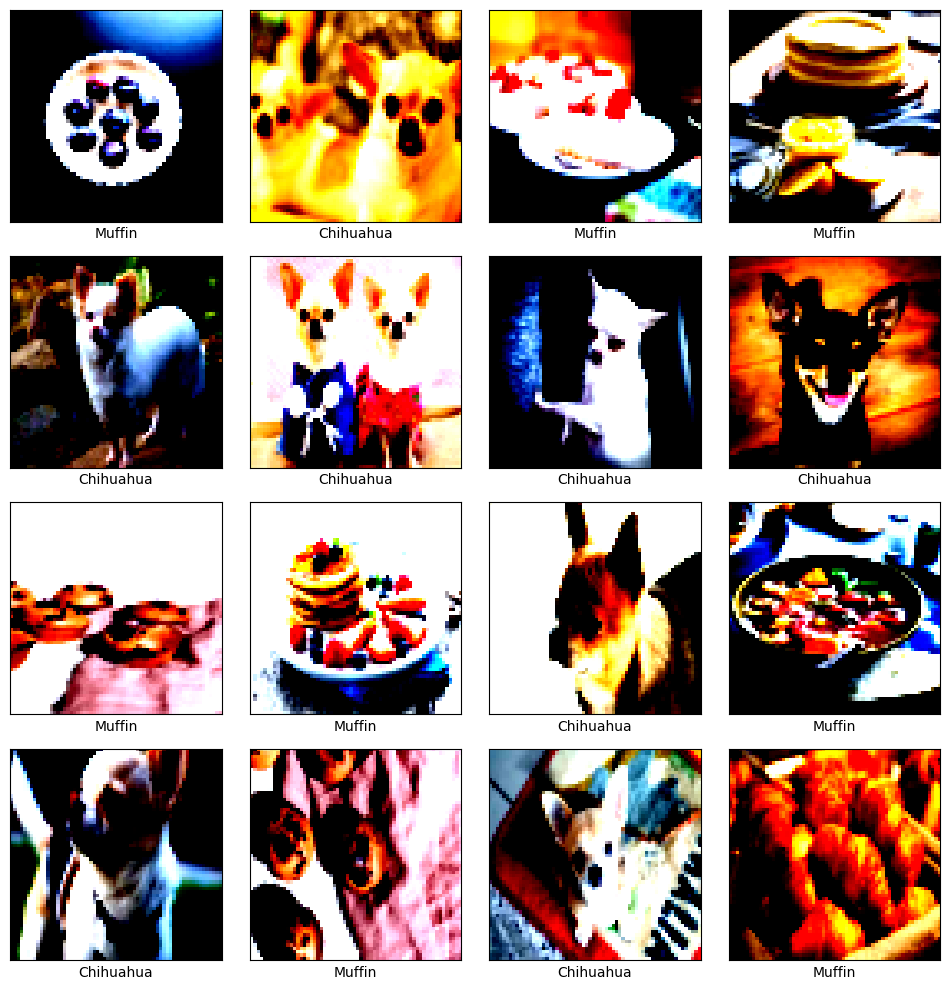

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(
        np.transpose(
            split_dataset['train'][i]["image"],
            (1 , 2, 0)
        )
    )
    if split_dataset['train'][i]["label"] == 0:
        label = 'Muffin'
    else:
        label = 'Chihuahua'
    plt.xlabel(f'{label}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [16]:
# Neural Network Module
class MuffinChihuahuaClassificator(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = create_model('resnet18', pretrained=True, num_classes=1)
        self.train_step_outputs = []
        self.valid_step_outputs = []
    
    def forward(self, x):
        return self.model(x)
    
    @staticmethod
    def loss(preds, targets):
        loss = F.binary_cross_entropy_with_logits(
          input=torch.squeeze(preds),
          target=targets.type_as(preds)
        )
        return loss

    def training_step(self, batch):
        return self._shared_step(batch, prefix="train")

    def on_train_epoch_end(self):
        # https://github.com/Lightning-AI/pytorch-lightning/releases/tag/2.0.0#bc-changes-pytorch
        self._shared_epoch_end(prefix="train")

    def validation_step(self, batch):
        return self._shared_step(batch, prefix="valid")

    def on_validation_epoch_end(self):
        self._shared_epoch_end(prefix="valid")

    def _shared_step(self, batch, prefix):
        x = batch["image"]
        y = batch["label"]
        
        # apply model to data
        y_hat = self(x)
        
        # batch size
        bs = torch.tensor(len(x), dtype=torch.int16).type_as(x)
        # loss
        loss = self.loss(
            preds=y_hat,
            targets=y.type(torch.FloatTensor)
        )
        self.log(
            name=f"{prefix}_loss",
            value=loss,
            prog_bar=True,
            logger=False,
            on_step=True,
            on_epoch=False
        )
        eval(f"self.{prefix}_step_outputs").append({"batch_size": bs, "loss": loss})
        return loss
    
    def _shared_epoch_end(self, prefix):
        # concat batch sizes
        batch_sizes = torch.stack(
            [x["batch_size"] for x in eval(f"self.{prefix}_step_outputs")]
        ).type_as(eval(f"self.{prefix}_step_outputs")[0]["loss"])

        # concat losses
        losses = torch.stack(
            [x["loss"] for x in eval(f"self.{prefix}_step_outputs")]
        ).type_as(eval(f"self.{prefix}_step_outputs")[0]["loss"])
        
        # clear outputs
        eval(f"self.{prefix}_step_outputs").clear()

        # calculating weighted mean loss
        avg_loss = torch.sum(losses * batch_sizes) / torch.sum(batch_sizes)

        self.log(
            name=f"loss/{prefix}",
            value=avg_loss,
            prog_bar=True,
            logger=False,
            on_step=False,
            on_epoch=True
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.005)

In [14]:
# Dataset Module
class ClassificationData(L.LightningDataModule):

    def train_dataloader(self):
        return train_dataloader
    
    def val_dataloader(self):
      return val_dataloader

In [18]:
if __name__ == "__main__":
    model = MuffinChihuahuaClassificator()
    data = ClassificationData()
    trainer = L.Trainer(max_epochs=50)
    trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
94        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
